# Satellite images segmentation

The task consists of creating a neural model able to perform semantic segmentation on satellite images into six (seven with the no information) different classes. The data used in this project is extracted from the [IGN](https://geoservices.ign.fr/telechargement) archives, and can be downloaded [here](https://drive.google.com/file/d/1y73mUPzS5Hhq1RjPXc9bxch-Nv6HlJem/view?usp=sharing).

Each tile in the dataset has a 1000x1000 resolution representing a 500m x 500m footprint (the resolution is 50cm per pixel).

The file structure of the dataset is as follows:
```none
├── ign
│   ├── annotations
│   │   ├── training
│   │   │   ├── aaa.png
│   │   │   ├── bbb.png
│   │   ├── validation
│   │   │   ├── xxx.png
│   │   │   ├── yyy.png
│   ├── images
│   │   ├── training
│   │   │   ├── aaa.png
│   │   │   ├── bbb.png
│   │   ├── validation
│   │   │   ├── xxx.png
│   │   │   ├── yyy.png

```

Here is an example of the image/mask contained in the dataset: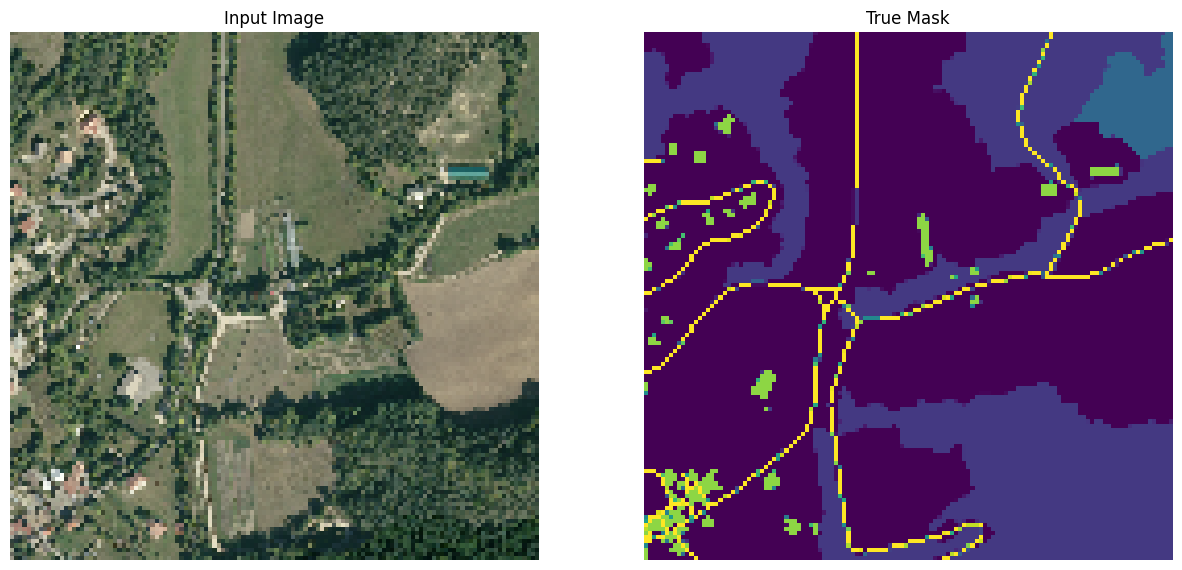

HINT: If the data does not fit into the memory, try by patching the image into smaller portions.

## Downloading the data

The data can be either downloaded from the link above and uploaded directly on Colab, or by running the following code snippet, that automatically downloads the data and unzip it.

In [2]:
!gdown 1y73mUPzS5Hhq1RjPXc9bxch-Nv6HlJem
!rm -rf ./ign
!unzip ign_dataset.zip
!rm ign_dataset.zip

Downloading...

From (original): https://drive.google.com/uc?id=1y73mUPzS5Hhq1RjPXc9bxch-Nv6HlJem

From (redirected): https://drive.google.com/uc?id=1y73mUPzS5Hhq1RjPXc9bxch-Nv6HlJem&confirm=t&uuid=a0c3e4d4-52d8-489f-bc11-856aa5d2fdb3

To: /content/ign_dataset.zip

100% 1.58G/1.58G [00:33<00:00, 47.5MB/s]

Archive:  ign_dataset.zip

   creating: ign/

   creating: ign/annotations/

   creating: ign/annotations/training/

  inflating: ign/annotations/training/c0_0915_6395.png  

  inflating: ign/annotations/training/c0_0920_6390.png  

  inflating: ign/annotations/training/c0_0935_6390.png  

  inflating: ign/annotations/training/c0_0935_6400.png  

  inflating: ign/annotations/training/c0_0955_6380.png  

  inflating: ign/annotations/training/c0_0960_6390.png  

  inflating: ign/annotations/training/c0_0975_6425.png  

  inflating: ign/annotations/training/c0_0990_6405.png  

  inflating: ign/annotations/training/c10_0915_6395.png  

  inflating: ign/annotations/training/c10_0920_6390.

## Multi-class segmentation

In this project, the input-target pair is composed by a $1000 \times 1000$ RGB image as visualized above, together with a $1000 \times 1000$ mask, that classifies each pixel by assigning to it a real number.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import cv2

import os
import glob
import sys

X_path = '/kaggle/input/ign-dataset/ign/images/'
Y_path = '/kaggle/input/ign-dataset/ign/annotations/'
# X_path = './ign/images/'
# Y_path = './ign/annotations/'

train_name = sorted(os.listdir(os.path.join(X_path, 'training')))
label_train_name = sorted(os.listdir(os.path.join(Y_path, 'training')))
test_name = sorted(os.listdir(os.path.join(X_path, 'validation')))
label_test_name = sorted(os.listdir(os.path.join(Y_path, 'validation')))

print(f"Number of elements in training set: {len(train_name)}")
print(f"Number of elements in test set: {len(test_name)}")

# As an example: load a sample to check the data
sample = np.random.randint(0, len(train_name))
x_sample_train = plt.imread(os.path.join(X_path, 'training', train_name[sample]))
y_sample_train = plt.imread(os.path.join(Y_path, 'training', train_name[sample]))

# print(np.unique(x_sample_train))
print(f"Image dataset interval: [{np.min(x_sample_train)}; {np.max(x_sample_train)}]")
print(f"Shape of x: {x_sample_train.shape}. Shape of y: {y_sample_train.shape}.")
# print(f"Unique values of y: {np.unique(y_sample_train)}.")

# x_train = []
# for idx in tqdm(range(len(train_name))):
#     x_train.append(cv2.imread(os.path.join(X_path, 'training', train_name[idx])))
# print(f"Min/Max values: {np.min(x_train)}, {np.max(x_train)}")
# x_train.clear()

# Inspecting classes in the masks
# y_train = []
# for idx in tqdm(range(len(train_name))):
#     y_train.append(cv2.imread(os.path.join(Y_path, 'training', train_name[idx])))

# labels = np.unique(y_train)
# print(labels)
# NUM_CLASSES = len(labels)
# y_train.clear()
# print(f"n.classes: {NUM_CLASSES}")

# plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
# plt.imshow(x_sample_train)
# plt.title(f'Image')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(y_sample_train)
# plt.title(f'Mask')
# plt.axis('off')

# plt.tight_layout()
# plt.show()

Number of elements in training set: 600
Number of elements in test set: 200
Image dataset interval: [0.054901961237192154; 0.9137254953384399]
Shape of x: (1000, 1000, 3). Shape of y: (1000, 1000).


In the example above, $\texttt{y_sample}$ contains 3 classes, represented by the three unique real numbers $[0, 0.00392157, 0.02352941]$.

Note that this approach is unusual in multiclass segmentation, where usually the mask is reshaped to be an $height \times width \times num. class$ binary array, where the pixel in position $(i, j)$ is classified as the class associated to the value 1, among the channels.

In this project, we assume that your data is processed as described above, since the metric used for the evaluation is implemented this way.  

## Metrics
The comparison metric for this project is the Dice Cofficient for multi-class segmentation (see the Lab about Segmentation for more informations). To apply this function, you are required to reshape both the predicted mask and the true mask to shape $\texttt{(batch_size, h, w, num_classes)}$, where $\texttt{num_classes}$ is the number of segmentation classes.

**IMPORTANT**: Remember to leave a print of average Dice Coefficient among the test set on the Notebook for a comparison. To do that, just measure the Dice Coffient by using the functions below for each batch, and take the average.

In [4]:
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=0.0001):
  y_true_f = tf.keras.backend.flatten(y_true)
  y_pred_f = tf.keras.backend.flatten(y_pred)

  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=7):
  dice = 0
  for index in range(numLabels):
    dice += dice_coef(y_true[:, :, :, index], y_pred[:, :, :, index])
  return dice / numLabels

## Project implementation

Good luck!

# Lorenzo Grandi - 1092188
### Dataset inspection
Check of the memory allocation, to choose whether patching is needed or not.


In [5]:
IMG_SHAPE = x_sample_train.shape[0]
IMG_SHAPE_RGB = x_sample_train.shape[-1]

mem_size_type_image_pixel = sys.getsizeof(x_sample_train[0,0,0])
mem_size_type_mask_pixel = sys.getsizeof(y_sample_train[0,0])
memory_train = (len(train_name) * IMG_SHAPE_RGB * IMG_SHAPE * IMG_SHAPE * mem_size_type_image_pixel +
                len(label_train_name) * IMG_SHAPE * IMG_SHAPE * mem_size_type_mask_pixel) / (1024 * 1024 * 1024) # B to GB
memory_test = (len(test_name) * IMG_SHAPE_RGB * IMG_SHAPE * IMG_SHAPE * mem_size_type_image_pixel +
               len(label_test_name) * IMG_SHAPE * IMG_SHAPE * mem_size_type_mask_pixel) / (1024 * 1024 * 1024)
print(f"Training set occupy {memory_train:.2f}GB of memory")
print(f"Training set occupy {memory_test:.2f}GB of memory")
print(f"Total memory used: {memory_train + memory_test:.2f}GB")

Training set occupy 62.58GB of memory
Training set occupy 20.86GB of memory
Total memory used: 83.45GB


The total memory necessary for the image loading is far from the memory space available in the RAM system, thus patching is mandatory.

#### Constants setup

In [87]:
NUM_CLASSES = 7

IMG_PATCH_DIM = 256
IMG_SHAPE = 1024
NUM_PATCHES = int((IMG_SHAPE ** 2) / (IMG_PATCH_DIM ** 2))
BATCH_SIZE = 4 * NUM_PATCHES

EPOCHS = 50

print(BATCH_SIZE)

64


### Image patching
To fit the tensors in the memory (too much space should be required if we load and process all in one) the images are patched. A generator function is created, so that the comuputation is performed on-the-fly.

<!-- #### Pre-patching
Images and masks are loaded, patched in a lower size format and stored as single patch. Therefore, processing will be performed directly on patches. -->

In [7]:
!pip install patchify
!pip install albumentations

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


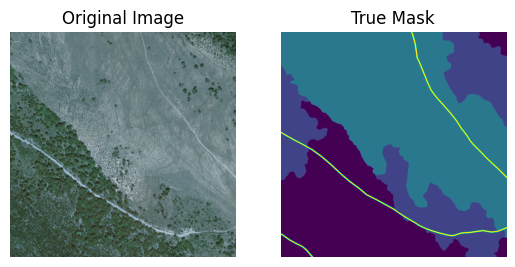

In [89]:
X_PATH = '/kaggle/input/ign-dataset/ign/images/'
Y_PATH = '/kaggle/input/ign-dataset/ign/annotations/'

image_set_name = sorted(os.listdir(os.path.join(X_PATH, 'training')))
mask_set_name = sorted(os.listdir(os.path.join(Y_PATH, 'training')))

img_idx = np.random.randint(0, len(image_set_name))
image = cv2.imread(os.path.join(X_PATH, 'training', image_set_name[img_idx]), cv2.IMREAD_COLOR)
mask = cv2.imread(os.path.join(Y_PATH, 'training', mask_set_name[img_idx]), cv2.IMREAD_GRAYSCALE)

plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Mask')
plt.imshow(mask)
plt.axis('off')

plt.show()

In [90]:
import os
import cv2
from tqdm import tqdm
from PIL import Image
from patchify import patchify
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import re

X_PATH = '/kaggle/input/ign-dataset/ign/images/'
Y_PATH = '/kaggle/input/ign-dataset/ign/annotations/'

X_PATCHES_PATH = '/kaggle/working/patches/images'
Y_PATCHES_PATH = '/kaggle/working/patches/annotations'

def save_patches(image_name, patches, save_dir, prefix, patch_type):
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            patch = patches[i, j]
            
            patch_filename = f"{image_name}_{i}_{j}.png"
            patch_folder = os.path.join(save_dir, prefix)
            
            if not os.path.exists(patch_folder):
                os.makedirs(patch_folder)
                
            patch_path = os.path.join(patch_folder, patch_filename)
            if patch_type == 'image':
                cv2.imwrite(patch_path, (patch).astype(np.uint8))
            elif patch_type == 'mask':
                cv2.imwrite(patch_path, (patch).astype(np.uint8))
            

def prepatch(type_set, x_path=X_PATH, y_path=Y_PATH, x_patches_path=X_PATCHES_PATH, y_patches_path=Y_PATCHES_PATH, patch_dim=IMG_PATCH_DIM):
    image_set_name = sorted(os.listdir(os.path.join(x_path, type_set)))
    mask_set_name = sorted(os.listdir(os.path.join(y_path, type_set)))
    
    images_patches = []
    masks_patches = []
    
    for idx in tqdm(range(len(image_set_name))):
        image_name = image_set_name[idx]
        mask_name = mask_set_name[idx]
        image = cv2.imread(os.path.join(x_path, type_set, image_name), cv2.IMREAD_COLOR)
        mask = cv2.imread(os.path.join(y_path, type_set, mask_name), cv2.IMREAD_GRAYSCALE)

        image = cv2.copyMakeBorder(image, 0, 24, 0, 24, cv2.BORDER_CONSTANT,value=[0,0,0])
        mask = cv2.copyMakeBorder(mask, 0, 24, 0, 24, cv2.BORDER_CONSTANT,value=0)
        
        image_patches = np.squeeze(patchify(image, (IMG_PATCH_DIM, IMG_PATCH_DIM, 3), step=IMG_PATCH_DIM))
        mask_patches = patchify(mask, (IMG_PATCH_DIM, IMG_PATCH_DIM), step=IMG_PATCH_DIM)
            
        
        image_name = re.sub(r'\.png$', '', image_name)
        mask_name = re.sub(r'\.png$', '', mask_name)
        save_patches(image_name, image_patches, x_patches_path, type_set, 'image')
        save_patches(mask_name, mask_patches, y_patches_path, type_set, 'mask')
    
train_dataset = prepatch('training')
val_dataset = prepatch('validation')

100%|██████████| 200/200 [00:21<00:00,  9.28it/s]


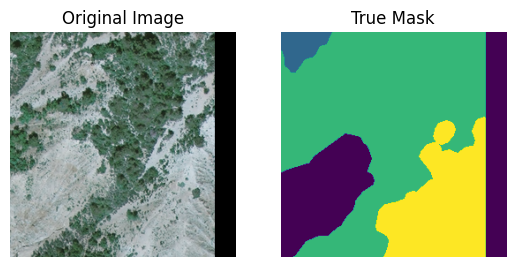

In [94]:
X_PATCHES_PATH = '/kaggle/working/patches/images'
Y_PATCHES_PATH = '/kaggle/working/patches/annotations'

image_set_name = sorted(os.listdir(os.path.join(X_PATCHES_PATH, 'training')))
mask_set_name = sorted(os.listdir(os.path.join(Y_PATCHES_PATH, 'training')))

img_idx = np.random.randint(0, len(image_set_name))
image = cv2.imread(os.path.join(X_PATCHES_PATH, 'training', image_set_name[img_idx]), cv2.IMREAD_COLOR)
mask = cv2.imread(os.path.join(Y_PATCHES_PATH, 'training', mask_set_name[img_idx]), cv2.IMREAD_GRAYSCALE)

plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Mask')
plt.imshow(mask)
plt.axis('off')

plt.show()

The generator create both the training and the validation sets, by loading the $1000\times 1000$ images and the masks, padding them to $1024\times 1024$ to make the image dimension being a multiple of the target patch size, patching into $128\times 128$ images and masks, pre-processing them respectively with normalization and one-hot encoding and applying data augmentation for the training set to prevent overfitting. The choice of performing data augmentation in pre-processed and patched images is done with the goal of increasing the randomness of the dataset, since the number of images increases from $600$ ($1024\times 1024$) to $38400$ ($128\times 128$), reducing further the likelihood of overfitting.

In [104]:
import tensorflow as tf
from tensorflow import keras
import os

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import cv2
from patchify import patchify
import albumentations as A

class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, image_dir, mask_dir, batch_size=BATCH_SIZE, img_patch_dim=IMG_PATCH_DIM, num_classes=NUM_CLASSES, augment=False, shuffle=True, **kwargs):
    super().__init__()
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.image_names = sorted(os.listdir(image_dir))
    self.mask_names = sorted(os.listdir(mask_dir))

    self.batch_size = batch_size
    self.img_patch_dim = img_patch_dim
    self.num_classes = num_classes
    self.augment = augment
    self.shuffle = shuffle

    self.indexes = np.arange(len(self.image_names))
    self.on_epoch_end()
    if self.augment:
      self.augmentation_pipeline = A.Compose([
              A.HorizontalFlip(p=0.5),
              A.VerticalFlip(p=0.5),
              A.RandomRotate90(p=0.25),
              A.ElasticTransform(alpha=0.5, sigma=20, alpha_affine=20, p=0.2),
              A.GridDistortion(p=0.2)
          ])

  def __len__(self):
    return int(np.ceil(len(self.image_names) / self.batch_size))

  def on_epoch_end(self):
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __load_image(self, img_path):
    image = cv2.imread(img_path, cv2.IMREAD_COLOR) / 255.
#     image = cv2.copyMakeBorder(image, 0, 24, 0, 24, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return image

  def __load_mask(self, mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#     mask = cv2.copyMakeBorder(mask, 0, 24, 0, 24, cv2.BORDER_CONSTANT, value=0)
    return mask

  def __getitem__(self, index):
    start_idx = index * self.batch_size
    end_idx = min((index + 1) * self.batch_size, len(self.image_names))
    indexes = self.indexes[start_idx:end_idx]

    batch_images = []
    batch_masks = []

    for i in indexes:
      img_path = os.path.join(self.image_dir, self.image_names[i])
      mask_path = os.path.join(self.mask_dir, self.mask_names[i])

      image = cv2.imread(img_path, cv2.IMREAD_COLOR) / 255.
      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

      if image is None or mask is None:
        continue

          # Data augmentation
      if self.augment:
        augmented = self.augmentation_pipeline(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']

          # Convert mask patch to categorical
      mask = to_categorical(mask, num_classes=self.num_classes).astype('float32')

      batch_images.append(image)
      batch_masks.append(mask)

    return np.array(batch_images), np.array(batch_masks)

# X_PATH = './ign/images/'
# Y_PATH = './ign/annotations/'
# X_PATH = '/kaggle/input/ign-dataset/ign/images/'
# Y_PATH = '/kaggle/input/ign-dataset/ign/annotations/'
X_PATCHES_PATH = '/kaggle/working/patches/images'
Y_PATCHES_PATH = '/kaggle/working/patches/annotations'

# Create data generators
training_data_generator = DataGenerator(os.path.join(X_PATCHES_PATH, 'training'), os.path.join(Y_PATCHES_PATH, 'training'), augment=True, workers=8, use_multiprocessing=True)
val_data_generator = DataGenerator(os.path.join(X_PATCHES_PATH, 'validation'), os.path.join(Y_PATCHES_PATH, 'validation'), augment=False, workers=8, use_multiprocessing=True)

Image batch shape: (64, 256, 256, 3)
Mask batch shape: (64, 256, 256, 7)


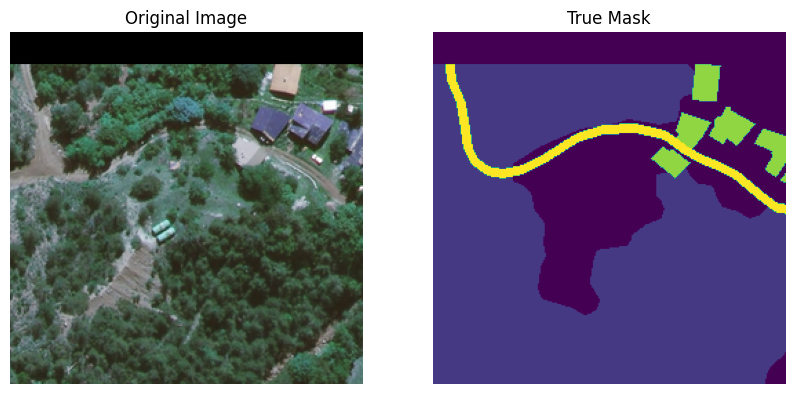

In [98]:
image_batch, mask_batch = next(iter(training_data_generator))
print(f"Image batch shape: {image_batch.shape}")
print(f"Mask batch shape: {mask_batch.shape}")

random_index = np.random.randint(0, len(image_batch))

image = image_batch[random_index]
true_mask = mask_batch[random_index]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('True Mask')
plt.imshow(np.argmax(true_mask, axis=-1))
plt.axis('off')

plt.show()

### Model implementation

The net implemented a residual U-Net, which gave very good results in similar segmentation tasks (https://arxiv.org/pdf/2211.12979v5). Instead of the classical horizontal convolutional block, a residual convolutional block is implemented, so that the block input tensor is added to the output and then down-sampled through max pooling operation. In order to prevent overfitting, dropout layers are introduced between the stages of the U-Net.

In [9]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam

# def u_net_down_block(inputs, filters, kernel_size=(3, 3), padding='same', activation='relu'):
#   res = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, activation=activation)(inputs)
#   res = tf.keras.layers.BatchNormalization()(res)
#   res = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, activation=activation)(res)
#   res = tf.keras.layers.BatchNormalization()(res)
#   res = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, activation=activation)(res)
#   res = tf.keras.layers.BatchNormalization()(res)

#   shortcut = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=1)(inputs)
#   shortcut = tf.keras.layers.BatchNormalization()(shortcut)

#   convDown = tf.keras.layers.Add()([shortcut, res])
#   pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(convDown)
#   pool = tf.keras.layers.Dropout(0.2)(pool)
#   return convDown, pool

# def u_net_up_block(inputs, skip, filters, kernel_size=(3, 3), padding='same', activation='relu'):
#   up = tf.keras.layers.UpSampling2D(size=(2, 2))(inputs)
#   up = tf.keras.layers.Dropout(0.2)(up)

#   concat = tf.keras.layers.Concatenate()([skip, up])
#   convUp = tf.keras.layers.Conv2D(filters, kernel_size, activation=activation, padding=padding)(concat)
#   convUp = tf.keras.layers.BatchNormalization()(convUp)
#   convUp = tf.keras.layers.Conv2D(filters, kernel_size, activation=activation, padding=padding)(convUp)
#   convUp = tf.keras.layers.BatchNormalization()(convUp)
#   convUp = tf.keras.layers.Conv2D(filters, kernel_size, activation=activation, padding=padding)(convUp)
#   convUp = tf.keras.layers.BatchNormalization()(convUp)
#   return convUp

# def u_net_model (input_shape=(IMG_PATCH_DIM, IMG_PATCH_DIM, 3), num_classes=NUM_CLASSES):
#   inputs = tf.keras.layers.Input(shape=input_shape)

#   # Encoder
#   conv1_enc, pool1_enc = u_net_down_block(inputs, 32)
#   conv2_enc, pool2_enc = u_net_down_block(pool1_enc, 64)
#   conv3_enc, pool3_enc = u_net_down_block(pool2_enc, 128)
#   conv4_enc, pool4_enc = u_net_down_block(pool3_enc, 256)

#   # Bottleneck
#   conv_bn = tf.keras.layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu')(pool4_enc)
#   conv_bn = tf.keras.layers.BatchNormalization()(conv_bn)
#   conv_bn = tf.keras.layers.SeparableConv2D(512, kernel_size=(3, 3), padding='same', activation='relu')(conv_bn)
#   conv_bn = tf.keras.layers.BatchNormalization()(conv_bn)
#   conv_bn = tf.keras.layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu')(conv_bn)
#   conv_bn = tf.keras.layers.BatchNormalization()(conv_bn)

#   # Decoder
#   conv4_dec = u_net_up_block(conv_bn, conv4_enc, 256)
#   conv3_dec = u_net_up_block(conv4_dec, conv3_enc, 128)
#   conv2_dec = u_net_up_block(conv3_dec, conv2_enc, 64)
#   conv1_dec = u_net_up_block(conv2_dec, conv1_enc, 32)

#   end = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')(conv1_dec)
#   end = tf.keras.layers.Dropout(0.4)(end)
#   end = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')(end)
#   end = tf.keras.layers.Dropout(0.4)(end)
#   end = tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu')(end)
#   outputs = tf.keras.layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(end)

#   model = Model(inputs=inputs, outputs=outputs)
#   return model

In [99]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras import layers

def u_net_model(img_size=(IMG_PATCH_DIM, IMG_PATCH_DIM,3), num_classes=NUM_CLASSES):
  inputs = keras.Input(shape=img_size)

  # Entry block
  x = layers.Conv2D(32, 3, strides=1, padding="same", activation='relu')(inputs)
  x = layers.BatchNormalization()(x)

  previous_block_activation = x  # Set aside residual

  # Encoder
  for filters in [64, 128, 256, 512]:
    x = layers.SeparableConv2D(filters, 3, padding="same", activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.SeparableConv2D(filters, 3, padding="same", activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(filters, 1, strides=2, padding="same", activation='relu')(previous_block_activation)
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

  # Decoder
  for filters in [512, 256, 128, 64]:
    x = layers.Conv2DTranspose(filters, 3, padding="same", activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(filters, 3, padding="same", activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D(2)(x)

    residual = layers.UpSampling2D(2)(previous_block_activation)
    residual = layers.Conv2D(filters, 1, padding="same")(residual)
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

  # Out block
  end = tf.keras.layers.SeparableConv2D(32, 3, padding='same', activation='relu')(x)
  end = tf.keras.layers.Dropout(0.4)(end)
  end = tf.keras.layers.SeparableConv2D(16, 3, padding='same', activation='relu')(end)
  end = tf.keras.layers.Dropout(0.4)(end)
  outputs = tf.keras.layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(end)

  # Define the model
  model = keras.Model(inputs, outputs)
  return model

In [105]:
strategy = tf.distribute.MultiWorkerMirroredStrategy()
with strategy.scope():
    model = u_net_model()
#     model.summary()

    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss = 'categorical_crossentropy',
        metrics=[dice_coef_multilabel]
    )
    print(len(model.layers))

68


Once the model is created and compiled, it is trained using an early stopping callback. A ModelCheckpoint, an early stopper and a learning rate scheduler are introduced to prevent overfitting.

In [106]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

checkpoint_folder = './checkpoints'
if not os.path.exists(checkpoint_folder):
                os.makedirs(checkpoint_folder)
checkpoint_path = f'{checkpoint_folder}/model_checkpoint.keras'

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_dice_coef_multilabel',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    save_freq='epoch'
)

early_stopper = EarlyStopping(monitor = 'val_dice_coef_multilabel',
                              min_delta = 1e-2,
                              patience = 7,
                              mode='max',
                              restore_best_weights = True,
                              verbose=1
                             )

reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef_multilabel',
                              verbose=1,
                              factor=0.2,
                              patience=5,
                              min_lr=1e-5
                              )

history = model.fit(training_data_generator,
                    validation_data=val_data_generator,
                    epochs=EPOCHS,
                    callbacks=[early_stopper, checkpoint_callback, reduce_lr]
                   )

Epoch 1/50


2024-07-12 12:01:42.178129: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_728/cond/StatefulPartitionedCall/functional_5_1/dropout_10_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef_multilabel: 0.2035 - loss: 1.2360
Epoch 1: val_dice_coef_multilabel improved from -inf to 0.13170, saving model to ./checkpoints/model_checkpoint.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - dice_coef_multilabel: 0.2037 - loss: 1.2349 - val_dice_coef_multilabel: 0.1317 - val_loss: 1.3931 - learning_rate: 0.0010
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef_multilabel: 0.2791 - loss: 0.8729
Epoch 2: val_dice_coef_multilabel did not improve from 0.13170
150/150 ━━━━━━━━━━━━━━━━━━━━ 299s 2s/step - dice_coef_multilabel: 0.2791 - loss: 0.8729 - val_dice_coef_multilabel: 0.1310 - val_loss: 1.3968 - learning_rate: 0.0010
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_coef_multilabel: 0.2952 - loss: 0.8192
Epoch 3: val_dice_coef_multilabel did not improve from 0.13170
150/150 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - dice_coef_multilabel: 0.2952 - loss: 0.8189 - val_dice_coef_multilabel: 0.0942 - val_loss: 2.3019 - 

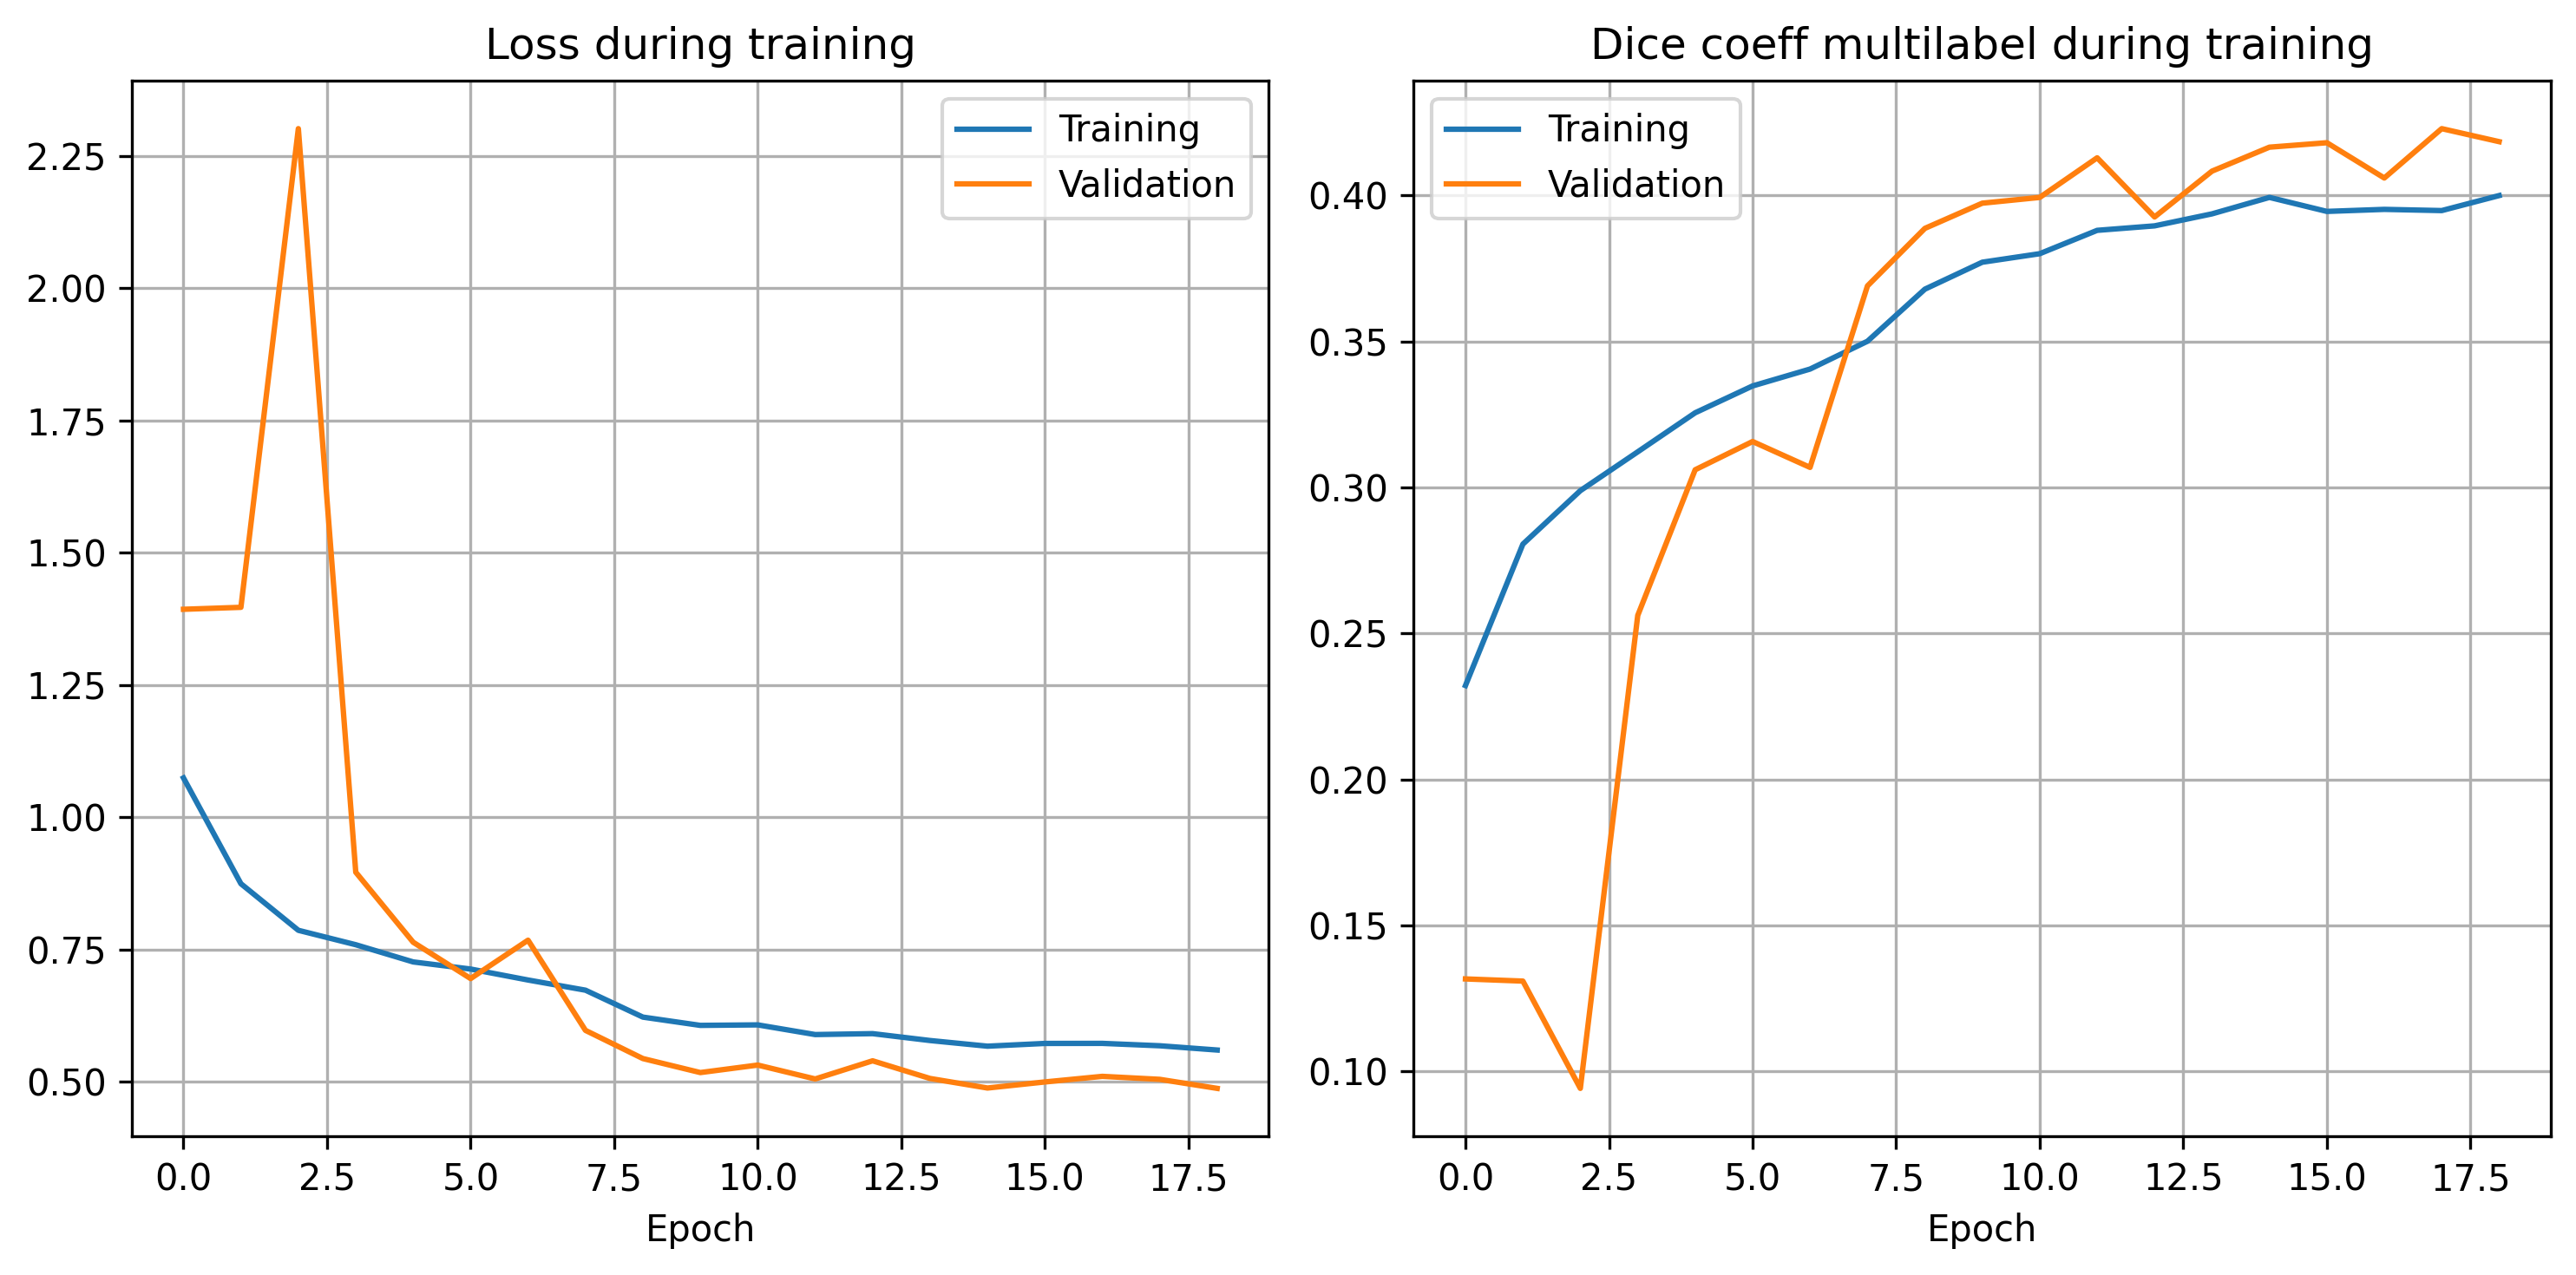

In [107]:
def display_history(history):
    loss_training = history.history['loss']
    dice_training = history.history['dice_coef_multilabel']

    loss_val = history.history['val_loss']
    dice_val = history.history['val_dice_coef_multilabel']

    plt.figure(figsize=(10, 5), dpi=300)

    # Display Loss
    plt.subplot(1, 2, 1)
    plt.plot(loss_training)
    plt.plot(loss_val)
    plt.grid()
    plt.title("Loss during training")
    plt.xlabel("Epoch")
    plt.legend(['Training', 'Validation'])

    # Display Dice coefficient
    plt.subplot(1, 2, 2)
    plt.plot(dice_training)
    plt.plot(dice_val)
    plt.grid()
    plt.title('Dice coeff multilabel during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])

    plt.tight_layout()
    plt.show()

display_history(history)

### Fine-tuning

In [109]:
with strategy.scope():
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=[dice_coef_multilabel])

    for layer in model.layers:
      layer.trainable = False

    for layer in model.layers[-17:]:
      layer.trainable = True

checkpoint_path = f'{checkpoint_folder}/model_checkpoint_fine_tune.keras'

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_dice_coef_multilabel',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    save_freq='epoch'
)

early_stopper = EarlyStopping(monitor='val_dice_coef_multilabel',
                              mode='max',
                              min_delta=1e-2,
                              patience=5,
                              restore_best_weights=True,
                              verbose=1
                             )

reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef_multilabel',
                              verbose=1,
                              factor=0.5,
                              patience=3,
                              min_lr=5e-6
                              )

history_fine = model.fit(training_data_generator,
                    validation_data=val_data_generator,
                    epochs=history.epoch[-1]+20,
                    initial_epoch=history.epoch[-1],
                    callbacks=[early_stopper, checkpoint_callback, reduce_lr]
                   )

model.save('./model_fine_tune.keras')

Epoch 19/38


2024-07-12 13:52:03.807655: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_408/cond/StatefulPartitionedCall/functional_5_1/dropout_10_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef_multilabel: 0.3913 - loss: 0.5742
Epoch 19: val_dice_coef_multilabel improved from -inf to 0.41215, saving model to ./checkpoints/model_checkpoint_fine_tune.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - dice_coef_multilabel: 0.3913 - loss: 0.5742 - val_dice_coef_multilabel: 0.4122 - val_loss: 0.5103 - learning_rate: 1.0000e-04
Epoch 20/38
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef_multilabel: 0.3990 - loss: 0.5634
Epoch 20: val_dice_coef_multilabel did not improve from 0.41215
150/150 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - dice_coef_multilabel: 0.3989 - loss: 0.5634 - val_dice_coef_multilabel: 0.4073 - val_loss: 0.5246 - learning_rate: 1.0000e-04
Epoch 21/38
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_coef_multilabel: 0.3977 - loss: 0.5599
Epoch 21: val_dice_coef_multilabel did not improve from 0.41215
150/150 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - dice_coef_multilabel: 0.3977 - loss: 0.5600 - val_dice_coef_multilabel: 0.407

In [ ]:
with strategy.scope():
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=[dice_coef_multilabel])

    for layer in model.layers:
      layer.trainable = False

    for layer in model.layers[:17]:
      layer.trainable = True

checkpoint_path = f'{checkpoint_folder}/model_checkpoint_fine_tune.keras'

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_dice_coef_multilabel',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    save_freq='epoch'
)

early_stopper = EarlyStopping(monitor='val_dice_coef_multilabel',
                              mode='max',
                              min_delta=1e-2,
                              patience=5,
                              restore_best_weights=True,
                              verbose=1
                             )

reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef_multilabel',
                              verbose=1,
                              factor=0.5,
                              patience=3,
                              min_lr=5e-6
                              )

history_fine = model.fit(training_data_generator,
                    validation_data=val_data_generator,
                    epochs=history_fine.epoch[-1]+20,
                    initial_epoch=history_fine.epoch[-1],
                    callbacks=[early_stopper, checkpoint_callback, reduce_lr]
                   )

model.save('./model_fine_tune_low.keras')

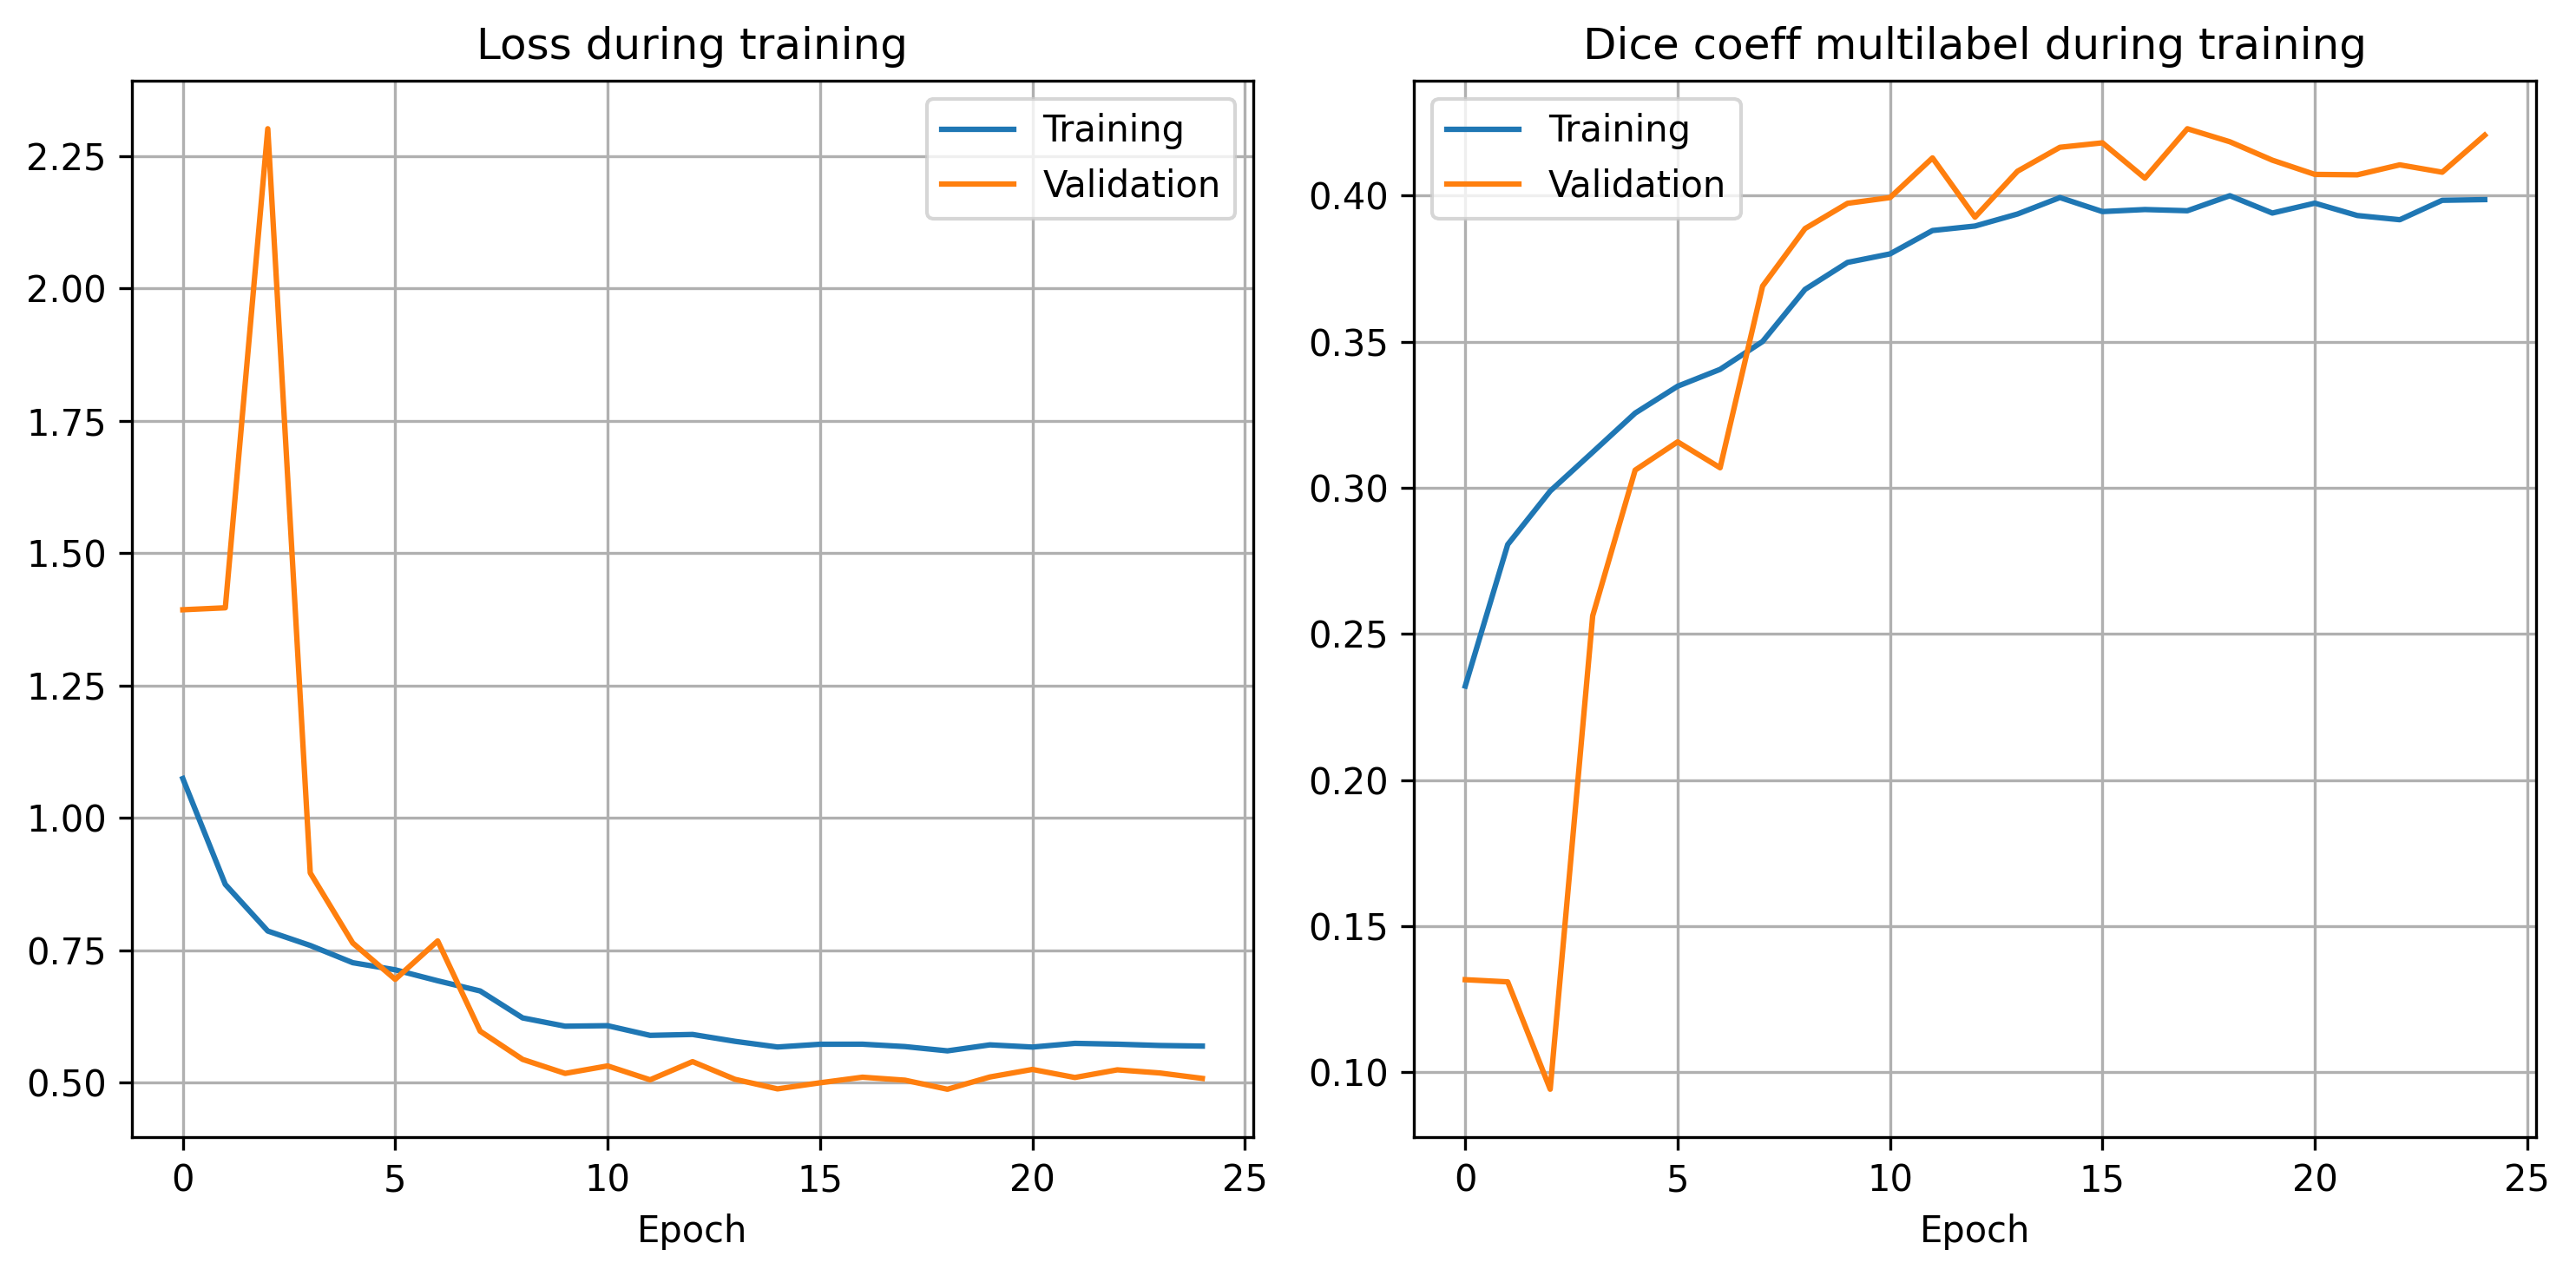

In [110]:
history.history['dice_coef_multilabel'] += history_fine.history['dice_coef_multilabel']
history.history['val_dice_coef_multilabel'] += history_fine.history['val_dice_coef_multilabel']

history.history['loss'] += history_fine.history['loss']
history.history['val_loss'] += history_fine.history['val_loss']

display_history(history)

#### Average Dice coefficient multilabel evaluation

In [ ]:
from tqdm import tqdm

def dice_coef(y_true, y_pred, smooth=0.0001):
  y_true_f = tf.keras.backend.flatten(y_true)
  y_pred_f = tf.keras.backend.flatten(y_pred)

  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=7):
  dice = 0
  for index in range(numLabels):
    dice += dice_coef(y_true[:, :, :, index], y_pred[:, :, :, index])
  return dice / numLabels

# total_dice = 0
# num_batches = len(val_data_generator)

# batch_dice_list = []
# for i in range(num_batches):
#     images, true_masks = val_data_generator[i]
#     predicted_masks = model.predict(images)
#     batch_dice = 0
#     print(f"Batch. {i}")
#     for j in tqdm(range(images.shape[0])):
#         batch_dice += dice_coef_multilabel(true_masks, predicted_masks, 7)

#     batch_dice /= images.shape[0]
#     batch_dice_list.append(batch_dice)
#     print(f"Batch dice: {batch_dice}")
#     total_dice += batch_dice

# average_dice = total_dice / num_batches
    

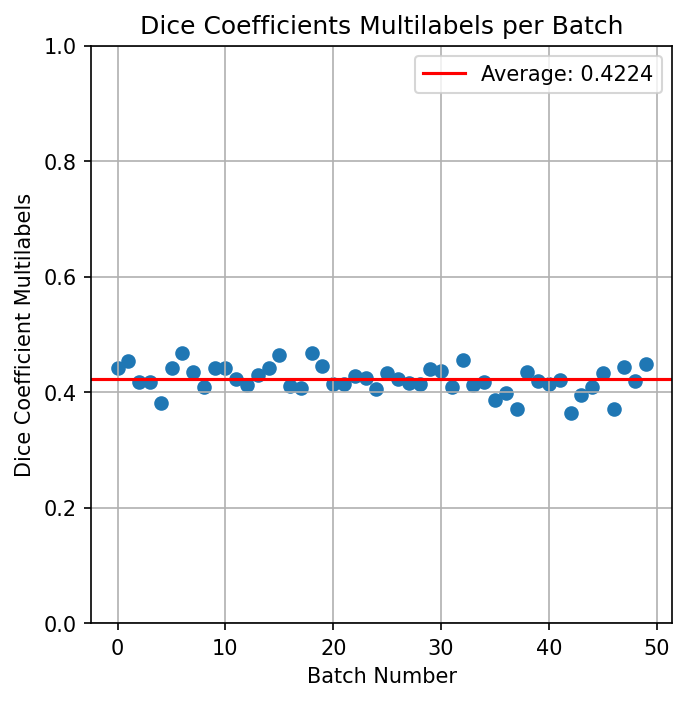

In [194]:
plt.figure(figsize=(5,5), dpi=150)
plt.scatter(range(num_batches), batch_dice_list)
plt.xlabel('Batch Number')
plt.ylabel('Dice Coefficient Multilabels')
plt.title('Dice Coefficients Multilabels per Batch')

plt.axhline(y=average_dice, color='r', linestyle='-', label=f'Average: {average_dice:.4f}')
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


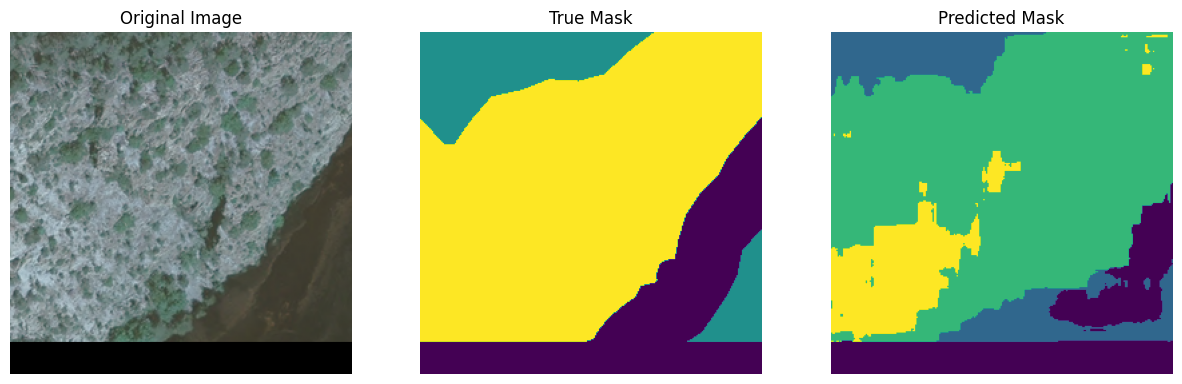

In [154]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Fetch a batch of images and masks from the validation data generator
image_batch, mask_batch = next(iter(val_data_generator))

# Select a random index from the batch
random_index = np.random.randint(0, len(image_batch))

# Get the image, true mask, and prediction for the random sample
image = image_batch[random_index]
true_mask = mask_batch[random_index]
predicted_mask = model.predict(np.expand_dims(image, axis=0))[0]

# Convert the predicted mask back from categorical if necessary
predicted_mask = np.argmax(predicted_mask, axis=-1)

# Plot the image, true mask, and predicted mask
plt.figure(figsize=(15, 5), dpi=300)

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('True Mask')
plt.imshow(np.argmax(true_mask, axis=-1))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Predicted Mask')
plt.imshow(predicted_mask)
plt.axis('off')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


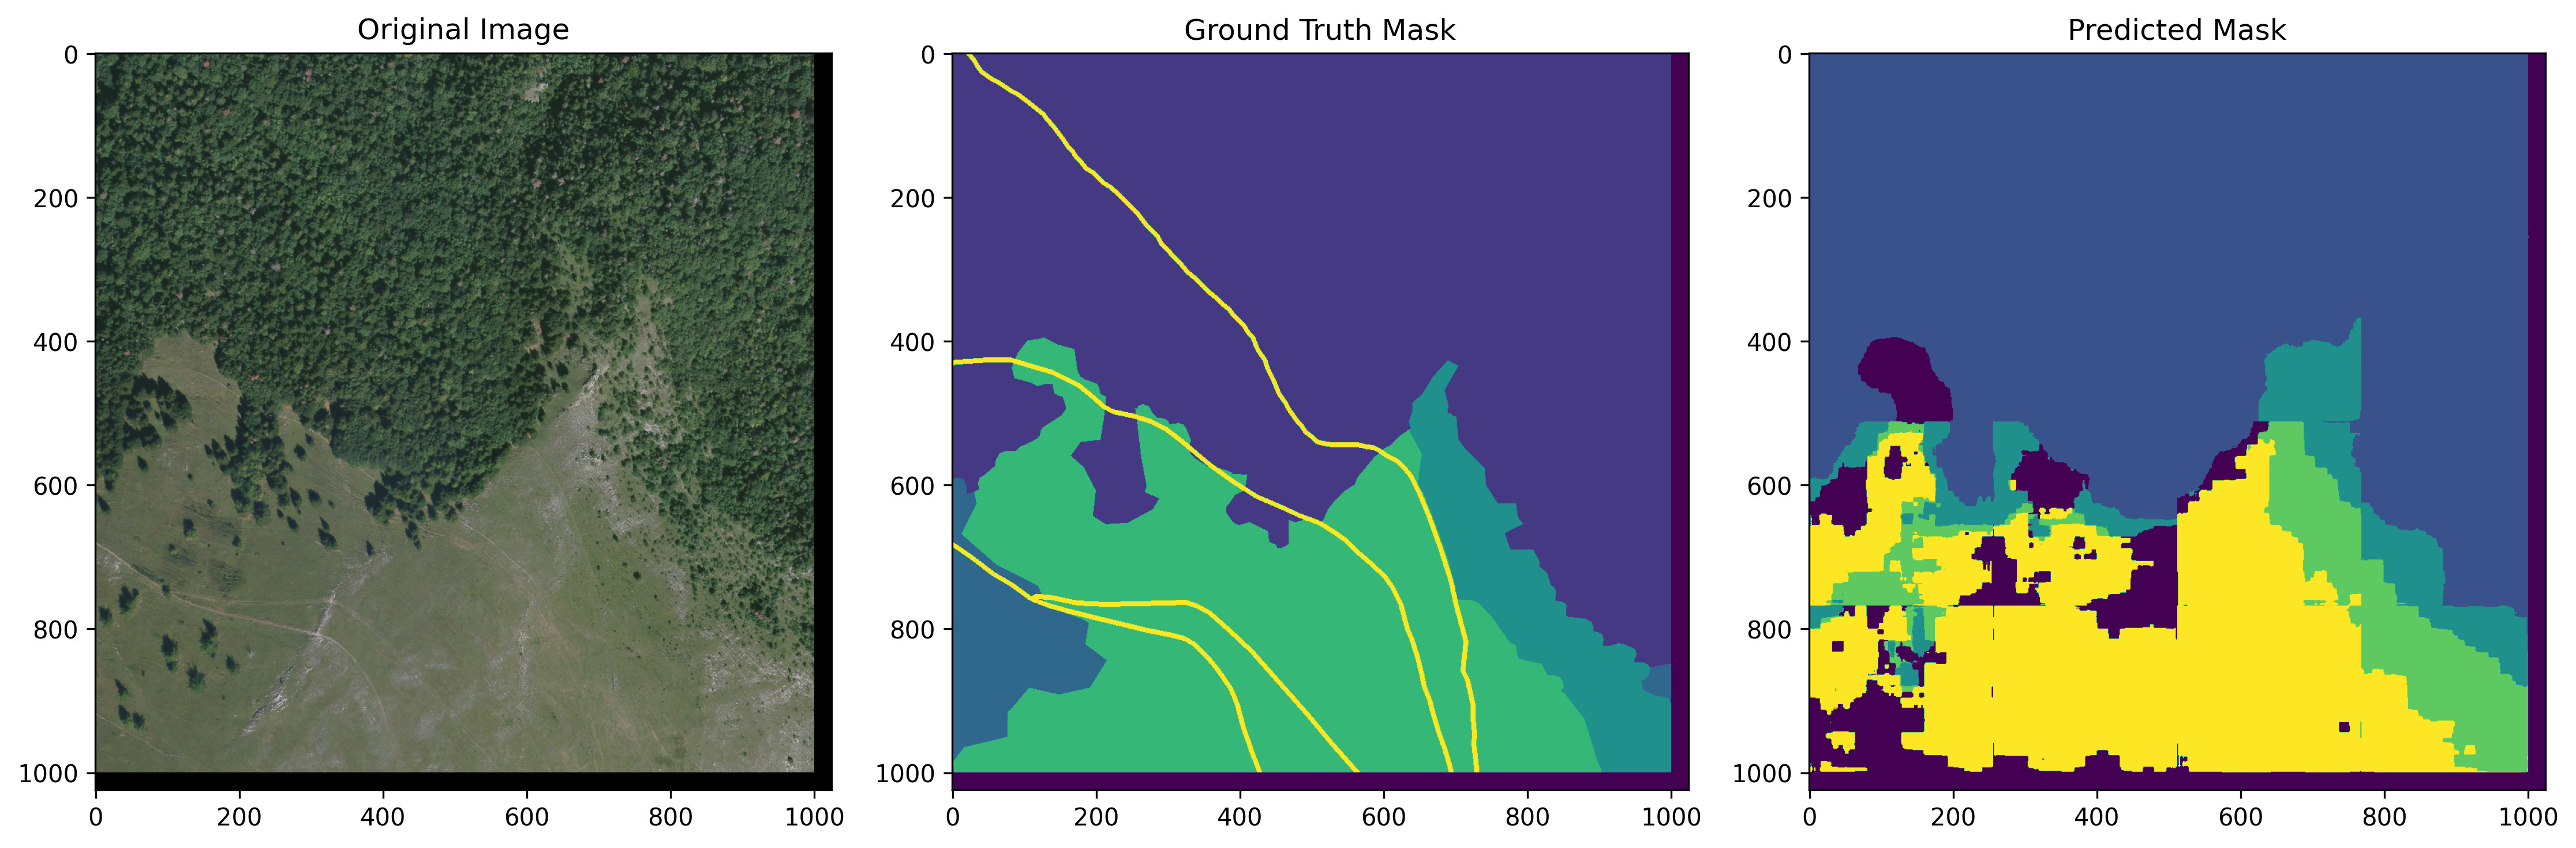

In [196]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.util import view_as_windows, view_as_blocks
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

# Paths to images and masks
X_PATH = '/kaggle/input/ign-dataset/ign/images/'
Y_PATH = '/kaggle/input/ign-dataset/ign/annotations/'

image_set_name = sorted(os.listdir(os.path.join(X_PATH, 'training')))
mask_set_name = sorted(os.listdir(os.path.join(Y_PATH, 'training')))

img_idx = np.random.randint(0, len(image_set_name))
image = cv2.imread(os.path.join(X_PATH, 'training', image_set_name[img_idx]), cv2.IMREAD_COLOR)
mask = cv2.imread(os.path.join(Y_PATH, 'training', mask_set_name[img_idx]), cv2.IMREAD_GRAYSCALE)

# Normalize the image and add padding
image = cv2.copyMakeBorder((image / 255.), 0, 24, 0, 24, cv2.BORDER_CONSTANT, value=[0, 0, 0])
mask = cv2.copyMakeBorder(mask, 0, 24, 0, 24, cv2.BORDER_CONSTANT, value=0)

# Patchify the image using skimage
patch_size = (256, 256, 3)
image_patches = view_as_windows(image, patch_size, step=256).reshape(-1, *patch_size)

# Prepare a list to store the predictions
predicted_patches = []

# Iterate over each patch and make predictions
for patch in image_patches:
    # Predict the mask for the patch
    prediction = model.predict(np.expand_dims(patch, axis=0))
    # Store the predicted patch
    predicted_patches.append(prediction[0])

# Convert the list to a numpy array
predicted_patches = np.array(predicted_patches)
predicted_patches = np.argmax(predicted_patches, axis=-1)

# Reshape the predicted patches to match the original patch structure
pred = predicted_patches.reshape(4, 4, patch_size[0], patch_size[1])

# Create a blank composite image
composite_image = np.zeros((composite_height, composite_width))

# Fill in the composite image with the patches
for i in range(pred.shape[0]):
    for j in range(pred.shape[1]):
        patch = pred[i, j, :, :]
        composite_image[i*patch_height:(i+1)*patch_height, j*patch_width:(j+1)*patch_width] = patch

# Plot the original image, ground truth mask, and the predicted mask
plt.figure(figsize=(15, 5), dpi=300)

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image[..., ::-1])  # Convert BGR to RGB

plt.subplot(1, 3, 2)
plt.title('Ground Truth Mask')
plt.imshow(mask)

plt.subplot(1, 3, 3)
plt.title('Predicted Mask')
plt.imshow(composite_image)

plt.tight_layout()
plt.show()